# generating a synthetic signal resulting from the advection of a vertical gradient by a background flow

In [1]:
import xarray as xr
import numpy as np

from scipy.special import erf 

import matplotlib.pyplot as plt

day = 86400 

---
## define spatial domain and timeseries

In [2]:
# build a time line
dt = 1/24/4 # days
T = 5

# spatial dimensions
x_max, dx = 10e3, 1
depth_max, dz = 100, .1

ds = xr.Dataset(None, coords=dict(time=("time", np.arange(0,T,dt)),
                                  z=("z", np.arange(-depth_max,0,1)),
                                  x=("x", np.arange(0,x_max, dx)),
                                 ))
# bathymetric slope
gamma = .01
ds = ds.assign_coords(h=ds.x*gamma, s=ds.x*np.sqrt(1+gamma**2))

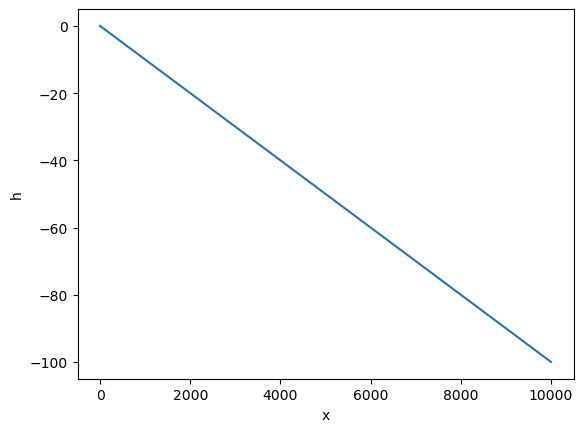

In [3]:
(-ds["h"]).plot()

---
## define the thermal stratification

We define the vertical stratification as the sum of a mild background stratification and a sharp gradients

In [4]:
# vertical thermal gradient
z_sharp, dz_sharp, delta_sharp = -50, 10, 1.
dTdz = lambda z: 1e-3 + (1-erf((z-z_sharp)**2/dz_sharp**2))**2*delta_sharp/dz_sharp # degC/m

In [5]:
ds["dTdz"] = dTdz(ds.z)
ds["T"] = ds.dTdz.cumulative_integrate("z")
ds["Tb"] = ds.T.interp(z=-ds.h)

### vertical profile of temperature

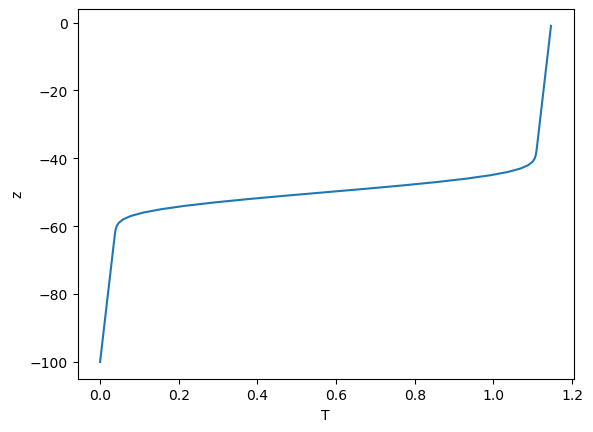

In [6]:
ds["T"].plot(y="z")

### seafloor temperature

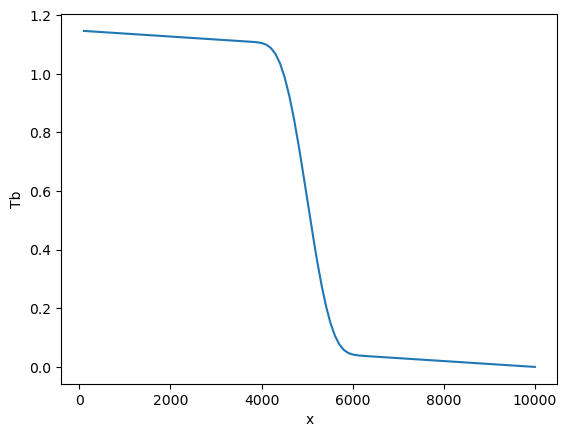

In [7]:
ds["Tb"].plot()

---
## define velocity fields and associated displacements

In [8]:
# velocity field along the seafloor
kb = 2*np.pi/10e3 # "apparent" wavelength
omega = 2*np.pi/2 # frequency
u = 0.05 # current amplitude

# on = onshore propagating phase
u_on = lambda t: u*np.cos(kb*ds.s+omega*t) # onshore propagating wave
u_off = lambda t: u*np.cos(kb*ds.s-omega*ds.time) # offshore propagating wave
u_uni = lambda t: ds.s*0+u*np.cos(omega*ds.time) # spatially uniform velocity field
# associated displacements
ds_on = lambda t: u*day/omega*np.sin(kb*ds.s+omega*t) # onshore propagating wave
ds_off = lambda t: -u*day/omega*np.sin(kb*ds.s-omega*ds.time) # offshore propagating wave
ds_uni = lambda t: ds.s*0+u*day/omega*np.sin(omega*ds.time) # spatially uniform velocity field

# apply and store in dataset
ds["u_on"] = u_on(ds.time)
ds["u_off"] = u_off(ds.time)
ds["u_uni"] = u_uni(ds.time)
ds["ds_on"] = ds_on(ds.time)
ds["ds_off"] = ds_off(ds.time)
ds["ds_uni"] = ds_uni(ds.time)

### compute associated temperature fields

In [9]:
# swap s and x
ds = ds.swap_dims(x="s")

ds["T_on"] = ds.Tb.interp(s = ds.s - ds.ds_on)
ds["T_off"] = ds.Tb.interp(s = ds.s - ds.ds_off)
ds["T_uni"] = ds.Tb.interp(s = ds.s - ds.ds_uni)

---

## plots

In [10]:
def plot_yrev(da, ax=None, title=None, **kwargs):
    if ax is None:
        fig, ax = plt.subplots(1,1)
    h = da.plot(ax=ax, **kwargs)
    h.colorbar.set_label("")
    ax.invert_yaxis()
    if title is not None:
        ax.set_title(title)
    return ax

def plot_all(suff, label):

    fig, axs = plt.subplots(2,2, sharey=True, sharex=True)

    ax = plot_yrev(ds["ds"+suff], ax=axs[0,0], title="displacement "+label)
    ax.set_xlabel("")
    ax = plot_yrev(ds["T"+suff], ax=axs[0,1], title="T "+label)
    ax.set_xlabel("")
    ax = plot_yrev(ds["T"+suff].differentiate("time"), ax=axs[1,0], title="dT/dt "+label, cmap="viridis")
    ax = plot_yrev((ds["T"+suff]-ds["T"+suff].mean("time")), ax=axs[1,1], title="T - mean(T) "+label, cmap="viridis")


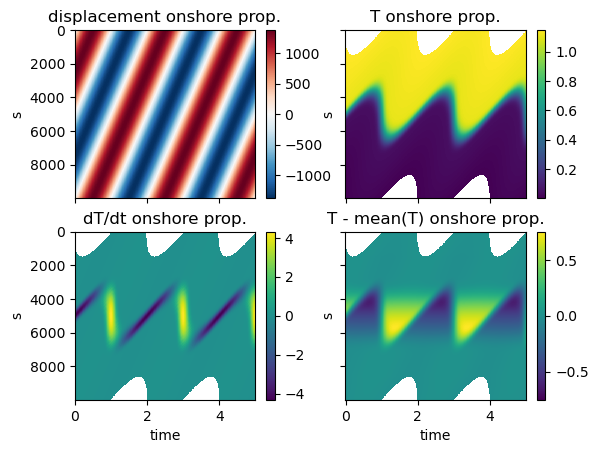

In [11]:
plot_all("_on", "onshore prop.")

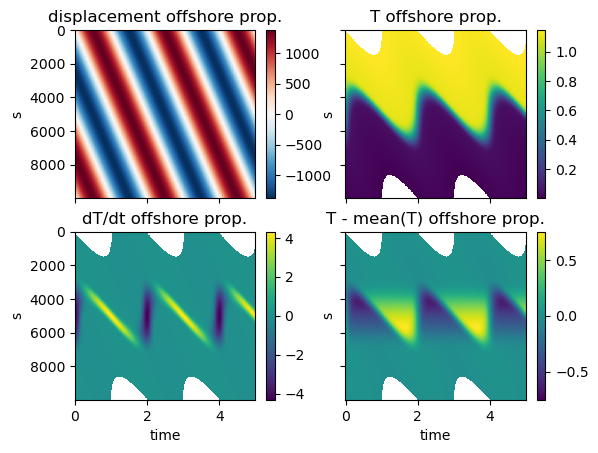

In [12]:
plot_all("_off", "offshore prop.")

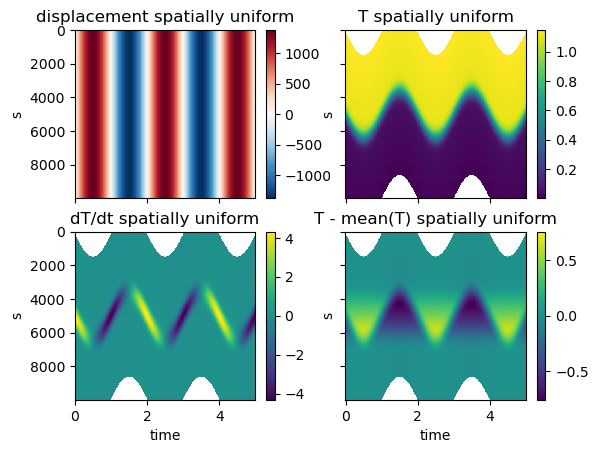

In [13]:
plot_all("_uni", "spatially uniform")

---

## analytical solutions for a steady flow and background flow.

Let's consider a steady flow $(u,v)$ and a thermal distribution $T(t=0, x, s) = T_0(\alpha x - s)$ prescribed in the seafloor two dimensional plane (cross-slope axis is $s$ and along-slope axis is $x$). The thermal distribution is one-dimensional and slanted with slope $\alpha$.
At any given time, the thermal distribution is given by:

$
\begin{align}
T(t, x, s) &= T(t=0, x - ut, s - vt ), \\
&= T_0 \big [ \alpha (x - ut) - (s - vt) \big ], \\
&= T_0 \big [ \alpha x - s - (\alpha u - v )t  \big ],
\end{align}
$

If a cable is lying at $x=0$, the perspective from the cable is given by:

$
\begin{align}
T(t, x=0, s)
&= T_0 \big [- s - (\alpha u - v )t  \big ],
\end{align}
$

So the apparent speed of propagation of the anomaly is $v - \alpha u$.
Multiple situations can occur:

- $\alpha=0$, i.e. the thermal stratification is along $s$ only. The apparent propagation speed equals then the flow in the $s$ direction. The flow in the $x$ direction ($u$) does not project on the apparent propagation speed.
- $u=0$, i.e. the flow is along the $s$ direction only. In this case, the apparent propagation speed equals not only the flow in the $s$ direction but also the total flow.
- in any other situations, the apparent propagation is a distortion of the actual flow
